Epoch 1/10
782/782 [==============================] - 28s 35ms/step - loss: 1.6357 - accuracy: 0.3990 - val_loss: 1.3336 - val_accuracy: 0.5086 - lr: 0.0010
Epoch 2/10
782/782 [==============================] - 27s 34ms/step - loss: 1.3259 - accuracy: 0.5260 - val_loss: 1.1648 - val_accuracy: 0.5835 - lr: 0.0010
Epoch 3/10
782/782 [==============================] - 15s 19ms/step - loss: 1.1788 - accuracy: 0.5824 - val_loss: 1.0983 - val_accuracy: 0.6238 - lr: 0.0010
Epoch 4/10
782/782 [==============================] - 15s 20ms/step - loss: 1.0877 - accuracy: 0.6129 - val_loss: 0.9375 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 5/10
782/782 [==============================] - 15s 19ms/step - loss: 1.0219 - accuracy: 0.6390 - val_loss: 0.9262 - val_accuracy: 0.6679 - lr: 0.0010
Epoch 6/10
782/782 [==============================] - 15s 19ms/step - loss: 0.9666 - accuracy: 0.6603 - val_loss: 0.9086 - val_accuracy: 0.6895 - lr: 0.0010
Epoch 7/10
782/782 [==============================] - 15s 

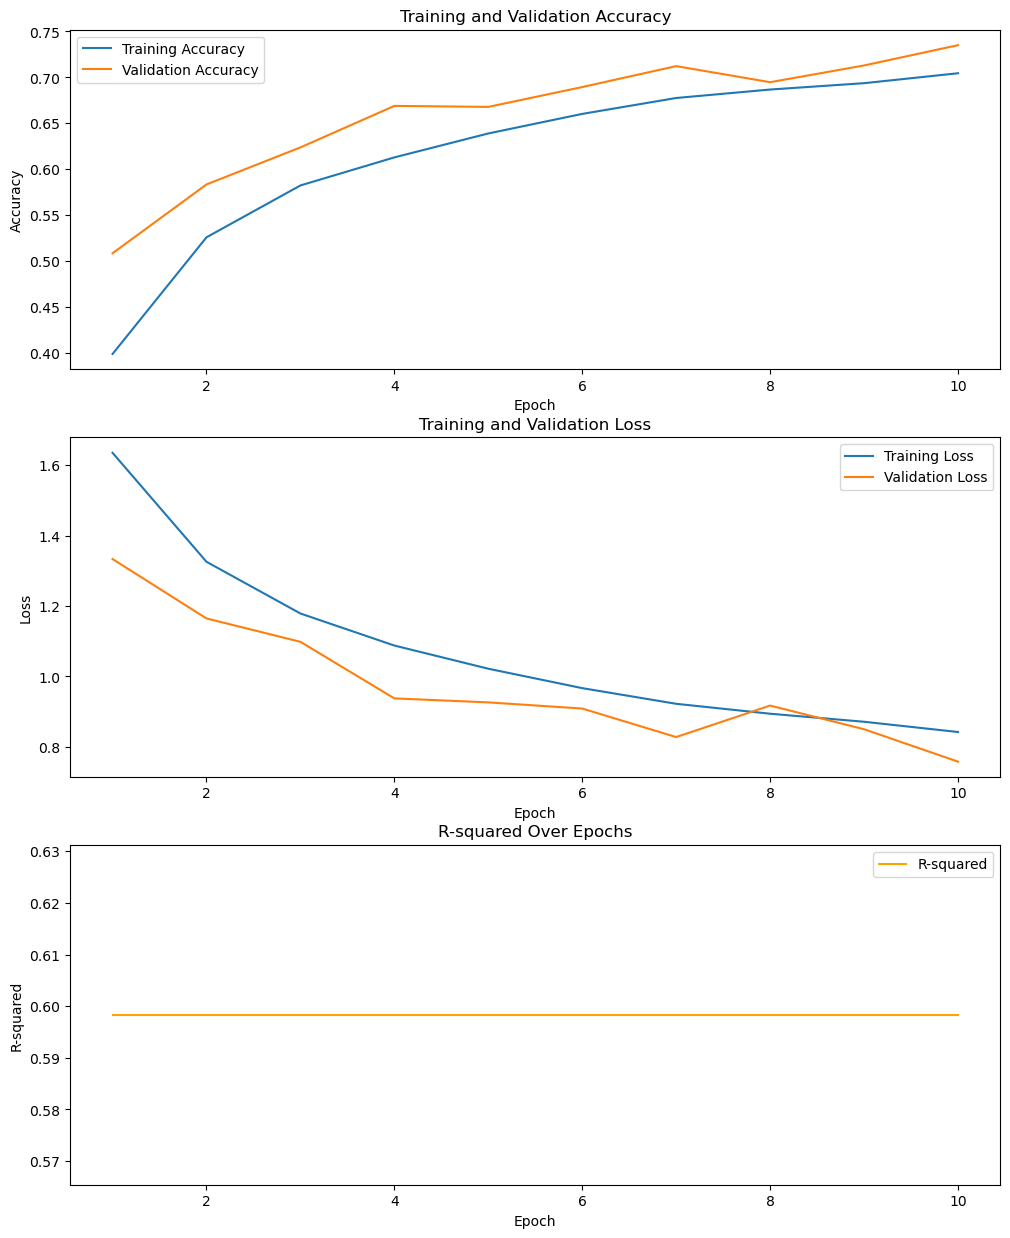

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from tensorflow.keras.callbacks import TensorBoard

# Load and preprocess the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use a learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model with data augmentation and TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[lr_scheduler, tensorboard_callback]
)

# Calculate R-squared during training
def r_squared(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Calculate R-squared for each epoch
r_squared_values = []
for i in range(10):
    y_true = test_labels
    y_pred = model.predict(test_images)
    r_squared_values.append(r_squared(y_true, y_pred).numpy())

# Training Accuracy and Loss per Epoch including R-squared
training_info = pd.DataFrame({
    'Epoch': range(1, 11),
    'Training Accuracy': history.history['accuracy'],
    'Training Loss': history.history['loss'],
    'R-squared': r_squared_values
})

# Create a figure and axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# Plot training & validation accuracy values
ax1.plot(range(1, 11), history.history['accuracy'], label='Training Accuracy')
ax1.plot(range(1, 11), history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training & validation loss values
ax2.plot(range(1, 11), history.history['loss'], label='Training Loss')
ax2.plot(range(1, 11), history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Plot R-squared values
ax3.plot(range(1, 11), r_squared_values, label='R-squared', color='orange')
ax3.set_title('R-squared Over Epochs')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('R-squared')
ax3.legend()

# Show the plot
plt.show()
